# Data Cleaning

In [366]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/raw/home_price.csv")
numerical_columns = ["Net_Metrekare", "Brüt_Metrekare", "Oda_Sayısı", "Fiyat", "Binanın_Kat_Sayısı", "Banyo_Sayısı"]
categorial_columns = ["Bulunduğu_Kat","Eşya_Durumu","Binanın_Yaşı","Isıtma_Tipi","Şehir","Kullanım_Durumu","Yatırıma_Uygunluk","Takas"]
df.head()

,Net_Metrekare,Brüt_Metrekare,Oda_Sayısı,Bulunduğu_Kat,Eşya_Durumu,Binanın_Yaşı,Isıtma_Tipi,Fiyat,Şehir,Binanın_Kat_Sayısı,Kullanım_Durumu,Yatırıma_Uygunluk,Takas,Tapu_Durumu,Banyo_Sayısı
0,120,150.0,4.0,4.Kat,Eşyalı,21 Ve Üzeri,Kombi Doğalgaz,950000.0,adana,6,Boş,NaN,Var,Kat Mülkiyeti,1.0
1,100,125.0,4.0,3.Kat,Boş,4,Kombi Doğalgaz,1250000.0,adana,10,Boş,NaN,Var,NaN,1.0
2,89,95.0,3.0,4.Kat,Boş,0 (Yeni),Kombi Doğalgaz,1750000.0,adana,14,Boş,Uygun,Var,NaN,1.0
3,40,55.0,2.0,6.Kat,Boş,0 (Yeni),Kombi Doğalgaz,1300000.0,adana,14,Boş,Uygun,Yok,NaN,1.0
4,140,150.0,4.0,Düz Giriş (Zemin),Boş,5-10,Klimalı,1700000.0,adana,4,Boş,Uygun,Yok,Kat Mülkiyeti,1.0


## Outliers and Duplicated Rows Handling 

In [367]:
import matplotlib.pyplot as plt
import seaborn as sns 


# Here I deleted any duplicated rows    
df.drop_duplicates(keep='first', inplace=True)



df = df[df["Net_Metrekare"] < 500]
df = df[df["Net_Metrekare"] > 50]

df = df[df["Brüt_Metrekare"] < 600]
df = df[df["Brüt_Metrekare"] > 50]

df = df[df["Oda_Sayısı"] < 9]

df = df[df["Banyo_Sayısı"] < 5]

df = df[df["Fiyat"] < 20000000]
df = df[df['Fiyat'] > 1000000]

# for col in numerical_columns:

#     df.boxplot(column = col)
#     plt.show()

df["Fiyat"] = np.log1p(df["Fiyat"])





## Imputation

In [368]:
from sklearn.preprocessing import MinMaxScaler , OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# I deleted the Tapu Durumu column here because it is half empty
df = df.drop("Tapu_Durumu" , axis = 1)

# I kept the encoder out of the pipeline because we have categorial, and numerical data. This might cause some data leakage but it is not very significant.
oe = OrdinalEncoder(encoded_missing_value=np.nan)

df[categorial_columns] = oe.fit_transform(df[categorial_columns])

df_train, df_test = train_test_split(df, test_size = 0.2, random_state= 44)

preprocessing_steps = [

    ('scaler', MinMaxScaler()),
    ('imputer', IterativeImputer(estimator=RandomForestRegressor(n_jobs=-1, n_estimators=10, random_state=0), max_iter=10, random_state=0))
]

preprocessing_pipeline = Pipeline(preprocessing_steps)
preprocessing_pipeline.set_output(transform='pandas')

preprocessing_pipeline.fit(df_train)


df = preprocessing_pipeline.transform(df)

minmax_pipeline = preprocessing_pipeline.named_steps['scaler']

df_array = minmax_pipeline.inverse_transform(df)

df = pd.DataFrame(data=df_array, columns=df.columns, index=df.index)
df[categorial_columns] = df[categorial_columns].round()
df[categorial_columns] = oe.inverse_transform(df[categorial_columns])

df = df.dropna()




c:\anaconda\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### Saving the dataset 

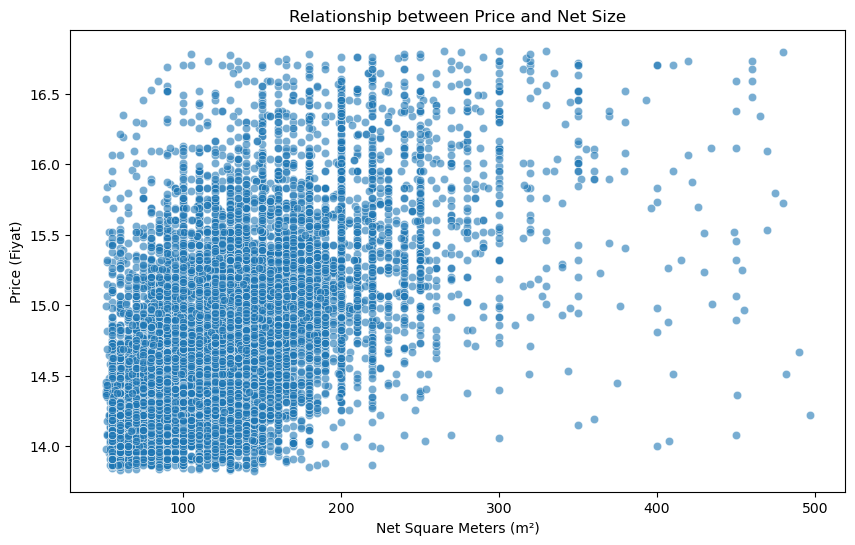

       Net_Metrekare  Brüt_Metrekare  Oda_Sayısı      Bulunduğu_Kat  \
1              100.0           125.0         4.0              3.Kat   
2               89.0            95.0         3.0              4.Kat   
4              140.0           150.0         4.0  Düz Giriş (Zemin)   
6               90.0           110.0         3.0              2.Kat   
8              105.0           145.0         4.0              8.Kat   
...              ...             ...         ...                ...   
20310          140.0           158.0         4.0              2.Kat   
20312          140.0           150.0         4.0              4.Kat   
20313          135.0           155.0         4.0              4.Kat   
20314          125.0           135.0         4.0  Düz Giriş (Zemin)   
20322           95.0           115.0         3.0              2.Kat   

      Eşya_Durumu Binanın_Yaşı       Isıtma_Tipi      Fiyat  Şehir  \
1             Boş            4    Kombi Doğalgaz  14.038655  adana   
2      

In [370]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Net_Metrekare', y='Fiyat', alpha=0.6)
plt.title('Relationship between Price and Net Size')
plt.xlabel('Net Square Meters (m²)')
plt.ylabel('Price (Fiyat)')
plt.show()

print(df)
# df.to_csv("../data/processed/cleaned_data.csv")